In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

In [43]:
# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

print('Dataset size :: ',X.shape)

Dataset size ::  (178, 13)


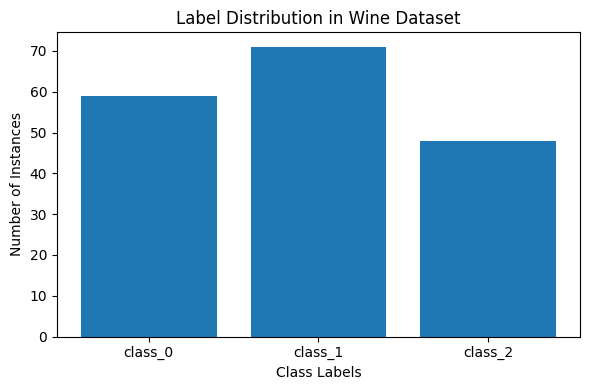

In [44]:
# Create a DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

# Visualize the label distribution
label_counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.bar(target_names, label_counts)
plt.xlabel("Class Labels")
plt.ylabel("Number of Instances")
plt.title("Label Distribution in Wine Dataset")
plt.tight_layout()
plt.show()

In [45]:
df


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


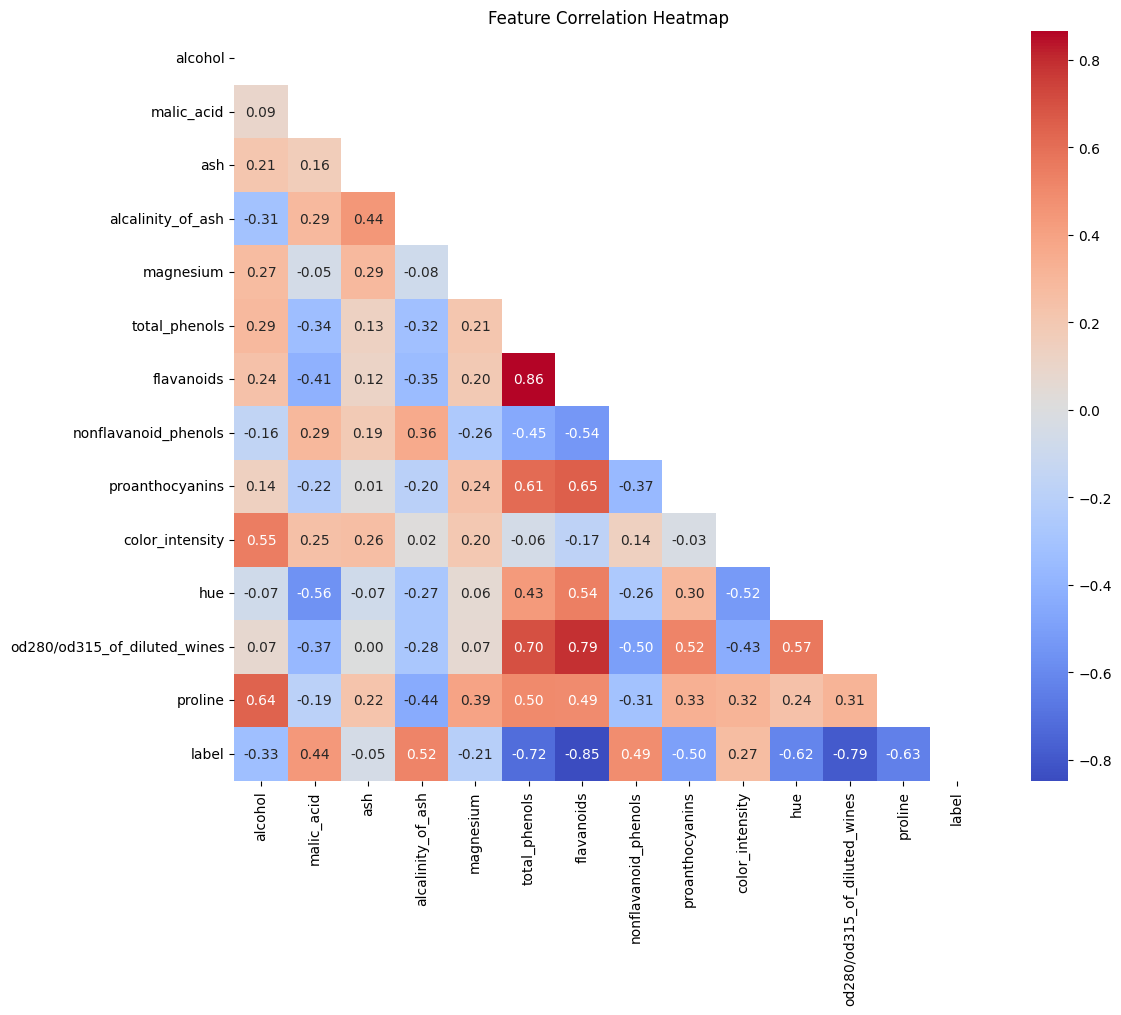

In [49]:
# Compute correlation matrix (excluding target)
corr_matrix = df.corr()
# Create a mask for the upper triangle (optional for cleaner visuals)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate the heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True)

# Add titles and layout tweaks
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
#plt.show()
plt.savefig("correlation_heatmap.png", dpi=300)

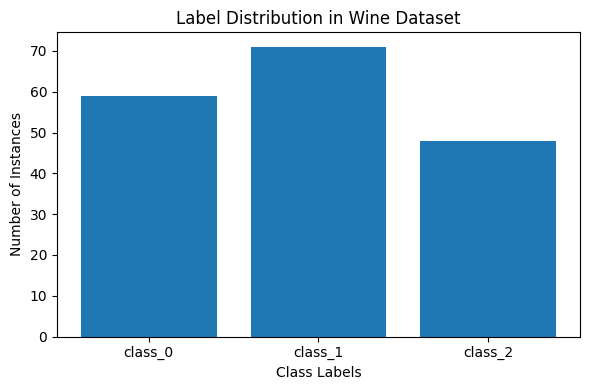

In [18]:
# Create a DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

# Visualize the label distribution
label_counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.bar(target_names, label_counts)
plt.xlabel("Class Labels")
plt.ylabel("Number of Instances")
plt.title("Label Distribution in Wine Dataset")
plt.tight_layout()
plt.show()

Binary label distribution:
binary_label
0    130
1     48
Name: count, dtype: int64


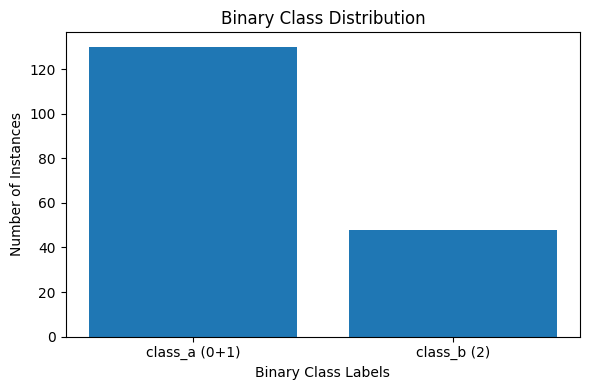

In [20]:
# Filter the dataset to include all original classes
df_binary = df.copy()

# Reframe labels: merge class_0 and class_1 as class_a (label 0), keep class_2 as class_b (label 1)
df_binary['binary_label'] = df_binary['label'].apply(lambda x: 0 if x in [0, 1] else 1)

# Print the binary label distribution
print("Binary label distribution:")
print(df_binary['binary_label'].value_counts())

# Optional: visualize the binary class distribution
plt.figure(figsize=(6, 4))
plt.bar(['class_a (0+1)', 'class_b (2)'], df_binary['binary_label'].value_counts().sort_index())
plt.xlabel("Binary Class Labels")
plt.ylabel("Number of Instances")
plt.title("Binary Class Distribution")
plt.tight_layout()
plt.show()

In [10]:
# Scoring metrics
scoring_metrics_binary = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

scoring_metrics_multi = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# Define models with pipelines (standardize data before training)
models = {
    'Naive Bayes': make_pipeline(StandardScaler(), GaussianNB()),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    'Gaussian Process': make_pipeline(StandardScaler(), GaussianProcessClassifier()),
    'SVM': make_pipeline(StandardScaler(), SVC())
}


In [23]:
# Evaluation function
def evaluate_models(X, y, model_dict, scoring_dict):
    results = {}
    for name, model in model_dict.items():
        metrics_result = {}
        for metric_name, scorer in scoring_dict.items():
            scores = cross_val_score(model, X, y, cv=5, scoring=scorer)
            metrics_result[metric_name] = {
                'mean': np.mean(scores),
                'std': np.std(scores)
            }
        results[name] = metrics_result
    return results

# Data for multiclass
X_multi = df.drop(columns='label')
y_multi = df['label']

# Data for binary
X_bin = df_binary.drop(columns=['label', 'binary_label'])
y_bin = df_binary['binary_label']

# Run evaluations
multi_results = evaluate_models(X_multi, y_multi, models, scoring_metrics_multi)
binary_results = evaluate_models(X_bin, y_bin, models, scoring_metrics_binary)

# Display nicely
def print_results(results, title):
    print(f"\n--- {title} ---")
    for model, metrics in results.items():
        print(f"\n{model}:")
        for metric, score in metrics.items():
            print(f"  {metric.capitalize():<10} = {score['mean']:.3f} ± {score['std']:.3f}")

print_results(multi_results, "Multiclass Classification Results")
print_results(binary_results, "Binary Classification Results")


--- Multiclass Classification Results ---

Naive Bayes:
  Accuracy   = 0.966 ± 0.021
  Precision  = 0.970 ± 0.019
  Recall     = 0.969 ± 0.020
  F1         = 0.968 ± 0.020

KNN:
  Accuracy   = 0.949 ± 0.038
  Precision  = 0.952 ± 0.035
  Recall     = 0.958 ± 0.030
  F1         = 0.951 ± 0.036

Gaussian Process:
  Accuracy   = 0.955 ± 0.029
  Precision  = 0.955 ± 0.028
  Recall     = 0.963 ± 0.023
  F1         = 0.956 ± 0.028

SVM:
  Accuracy   = 0.983 ± 0.022
  Precision  = 0.986 ± 0.018
  Recall     = 0.983 ± 0.024
  F1         = 0.984 ± 0.022

--- Binary Classification Results ---

Naive Bayes:
  Accuracy   = 0.960 ± 0.034
  Precision  = 0.891 ± 0.089
  Recall     = 0.980 ± 0.040
  F1         = 0.931 ± 0.058
  Roc_auc    = 0.967 ± 0.033

KNN:
  Accuracy   = 0.972 ± 0.018
  Precision  = 0.927 ± 0.065
  Recall     = 0.980 ± 0.040
  F1         = 0.950 ± 0.029
  Roc_auc    = 0.975 ± 0.017

Gaussian Process:
  Accuracy   = 0.966 ± 0.033
  Precision  = 0.897 ± 0.094
  Recall     = 1.000 ±

In [24]:
# Function to convert evaluation results to DataFrame
def results_to_dataframe(results):
	rows = []
	for model_name, metrics in results.items():
		row = {'Model': model_name}
		for metric_name, score in metrics.items():
			row[f"{metric_name}_mean"] = score['mean']
			row[f"{metric_name}_std"] = score['std']
		rows.append(row)
	return pd.DataFrame(rows)

# Convert evaluation results to DataFrames
df_multi_results = results_to_dataframe(multi_results)
df_binary_results = results_to_dataframe(binary_results)

# Display in Jupyter Notebook
from IPython.display import display

display(df_multi_results.style.set_caption("Multiclass Classification Results"))
display(df_binary_results.style.set_caption("Binary Classification Results"))


,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,Naive Bayes,0.966349,0.021133,0.969973,0.018814,0.969048,0.019505,0.967684,0.020086
1,KNN,0.949365,0.037911,0.951542,0.035074,0.958413,0.029515,0.951160,0.036311
2,Gaussian Process,0.955079,0.028990,0.954639,0.028458,0.962857,0.023015,0.955946,0.027899
3,SVM,0.983333,0.022222,0.985606,0.017991,0.983016,0.023913,0.983504,0.021817


,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,Naive Bayes,0.960476,0.033658,0.890909,0.089072,0.980000,0.040000,0.931429,0.058134,0.966923,0.032599
1,KNN,0.971905,0.017573,0.926667,0.064636,0.980000,0.040000,0.950239,0.028962,0.974615,0.017303
2,Gaussian Process,0.966190,0.032590,0.897483,0.093555,1.000000,0.000000,0.943387,0.052456,0.976923,0.022427
3,SVM,0.960952,0.041533,0.940000,0.080000,0.920000,0.097980,0.927251,0.075702,0.948462,0.057027


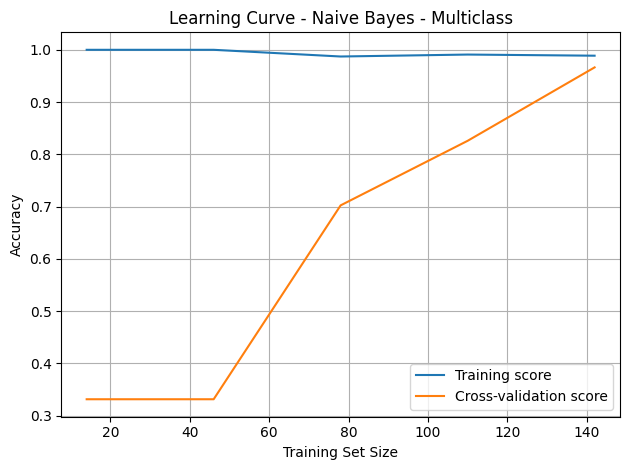

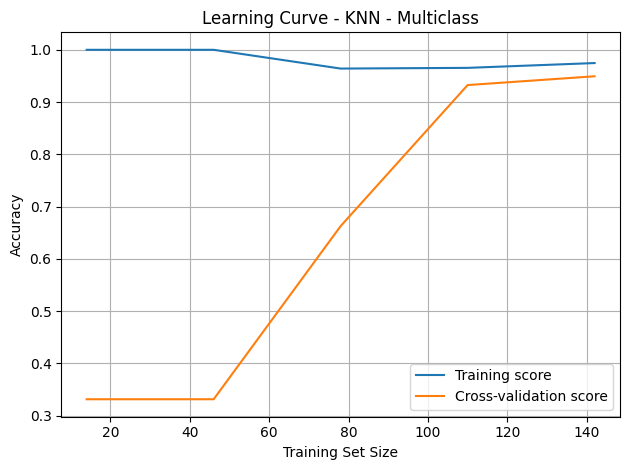

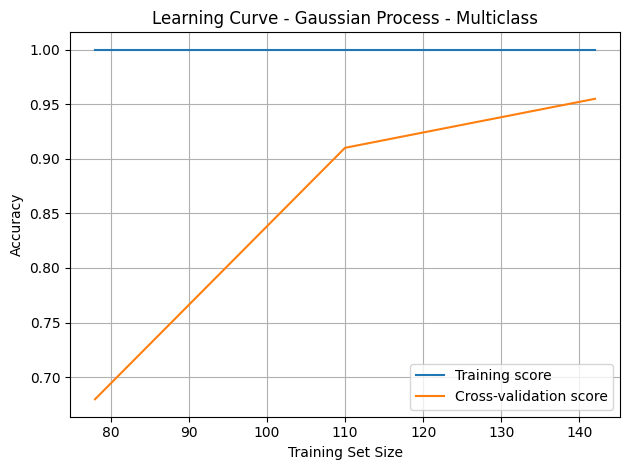

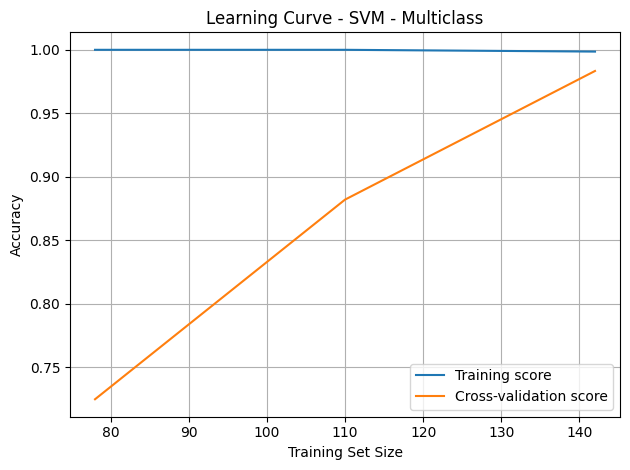

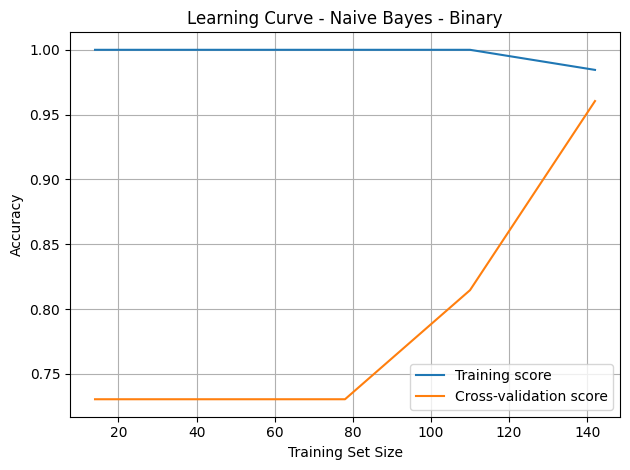

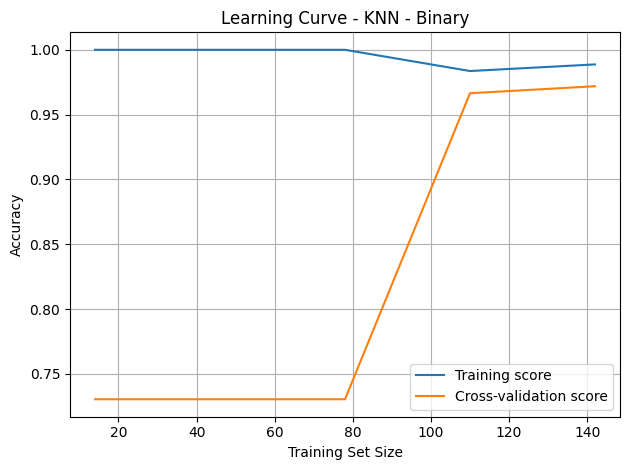

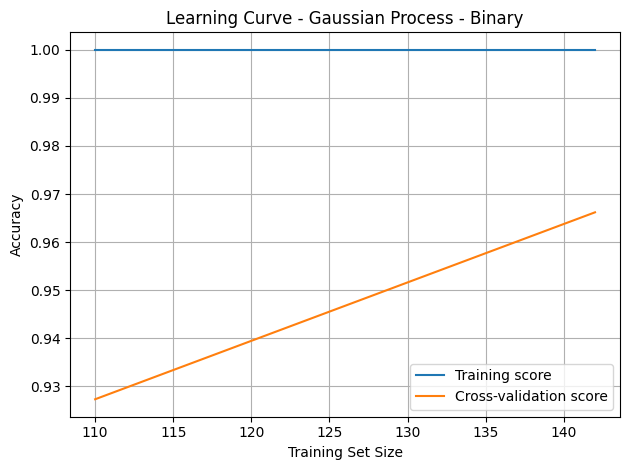

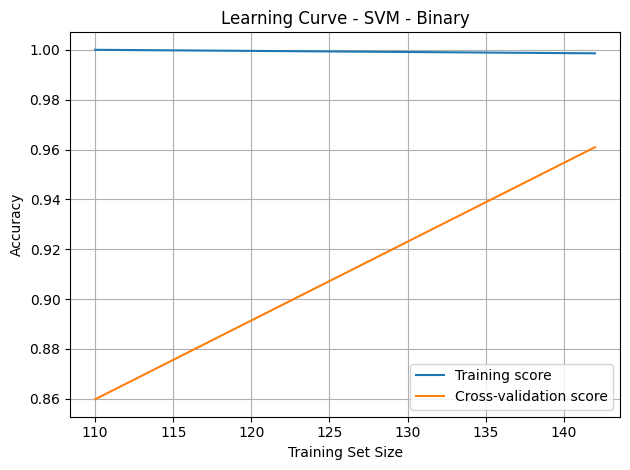

In [25]:
def plot_learning_curve(estimator, X, y, title, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
    plt.title(f"Learning Curve - {title}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Learning curves for all models - multiclass
for name, model in models.items():
    plot_learning_curve(model, X_multi, y_multi, f"{name} - Multiclass")

# Learning curves for all models - binary
for name, model in models.items():
    plot_learning_curve(model, X_bin, y_bin, f"{name} - Binary")


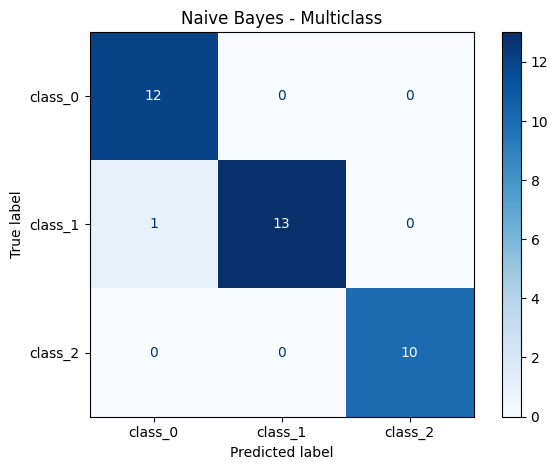

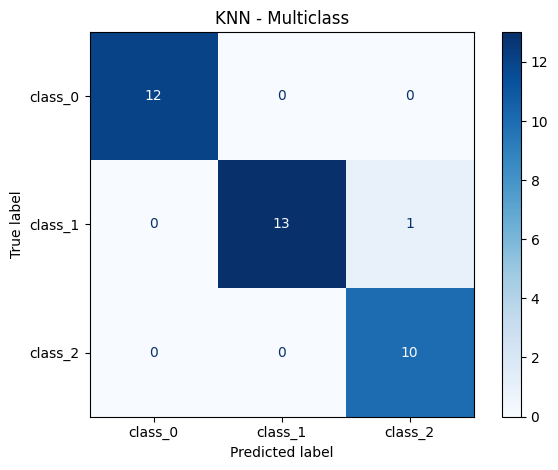

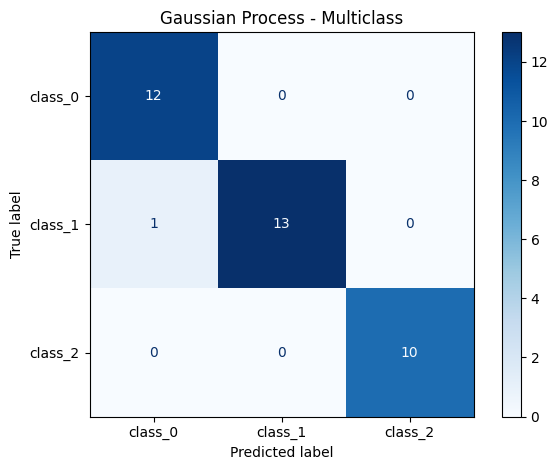

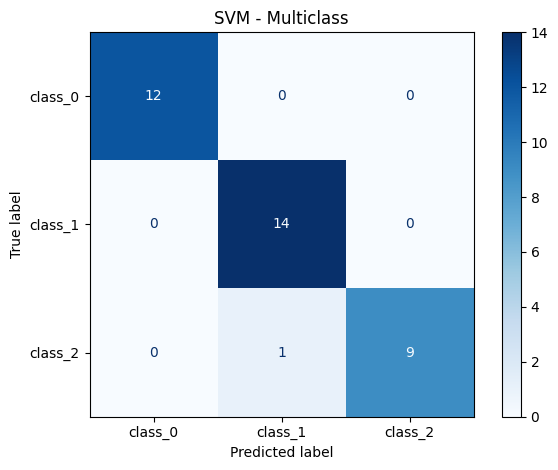

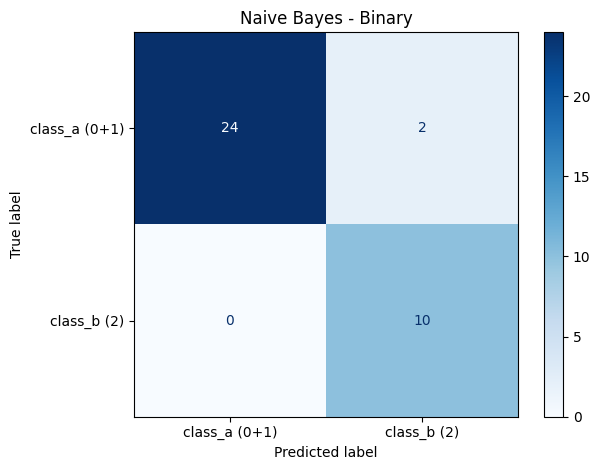

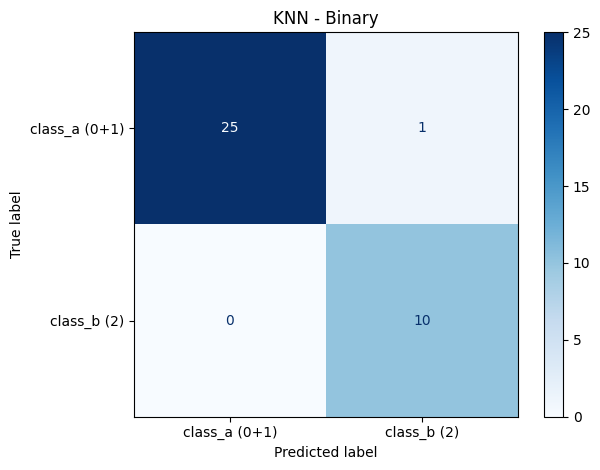

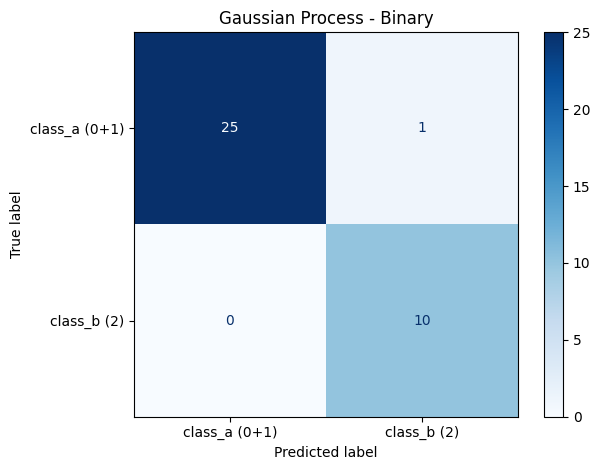

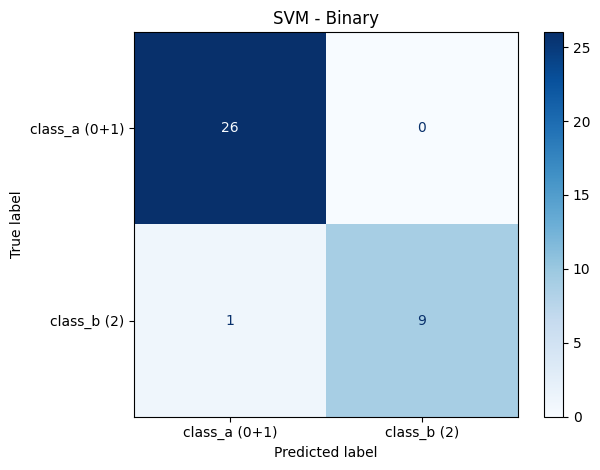

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Function to plot confusion matrix
def plot_conf_matrix(model, X, y, labels, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Confusion matrices for all models - multiclass
for name, model in models.items():
    plot_conf_matrix(model, X_multi, y_multi, wine.target_names, f"{name} - Multiclass")

# Confusion matrices for all models - binary
for name, model in models.items():
    plot_conf_matrix(model, X_bin, y_bin, ['class_a (0+1)', 'class_b (2)'], f"{name} - Binary")



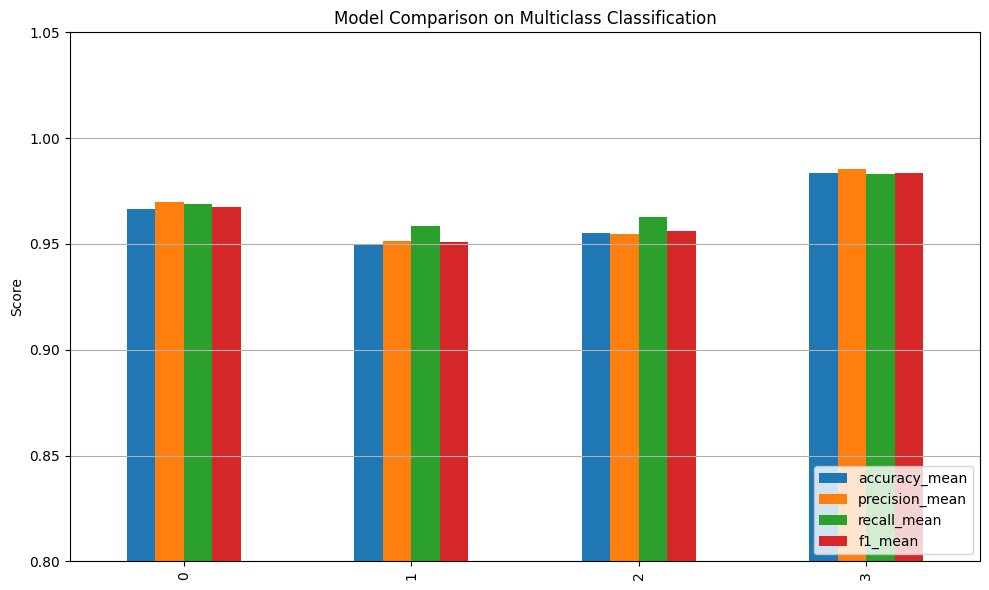

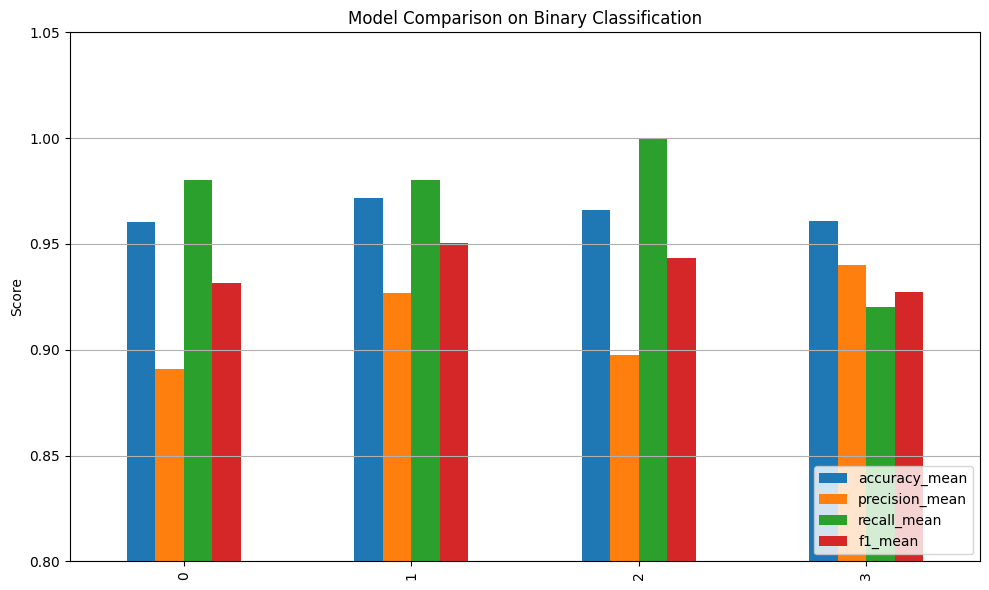

In [27]:
def plot_metric_comparison(df_results, task_name):
    metrics = ['accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean']
    df_plot = df_results[metrics]
    df_plot.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Model Comparison on {task_name}')
    plt.ylabel('Score')
    plt.ylim(0.8, 1.05)
    plt.grid(True, axis='y')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

plot_metric_comparison(df_multi_results, "Multiclass Classification")
plot_metric_comparison(df_binary_results, "Binary Classification")


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Function to train and evaluate each model and print class-wise metrics
def evaluate_confusion_and_report(models, X, y, labels, task_name):
    print(f"\n{'='*20} {task_name.upper()} CLASSIFICATION {'='*20}")
    for name, model in models.items():
        print(f"\n--- {name} ---")
        
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(cm)

        # Classification report (precision, recall, f1-score per class)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=labels))

# Labels
multi_labels = wine.target_names
binary_labels = ['class_a (0+1)', 'class_b (2)']

# Evaluate all models on multiclass classification
evaluate_confusion_and_report(models, X_multi, y_multi, multi_labels, task_name="Multiclass")

# Evaluate all models on binary classification
evaluate_confusion_and_report(models, X_bin, y_bin, binary_labels, task_name="Binary")


==================== MULTICLASS CLASSIFICATION ====================

--- Naive Bayes ---

Confusion Matrix:
[[12  0  0]
 [ 1 13  0]
 [ 0  0 10]]

Classification Report:
              precision    recall  f1-score   support

     class_0       0.92      1.00      0.96        12
     class_1       1.00      0.93      0.96        14
     class_2       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36


--- KNN ---

Confusion Matrix:
[[12  0  0]
 [ 0 13  1]
 [ 0  0 10]]

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      0.93      0.96        14
     class_2       0.91      1.00      0.95        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to calculate class-wise accuracy from confusion matrix
def get_classwise_accuracy(cm):
    return cm.diagonal() / cm.sum(axis=1)

# Evaluate and display class-wise accuracy
def evaluate_classwise_accuracy(models, X, y, labels, task_name):
    print(f"\n{'='*20} {task_name.upper()} CLASS-WISE ACCURACY {'='*20}")
    for name, model in models.items():
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        class_acc = get_classwise_accuracy(cm)

        # Print class-wise accuracy
        print(f"\n--- {name} ---")
        for label, acc in zip(labels, class_acc):
            print(f"  {label}: {acc:.3f}")

# Multiclass class-wise accuracy
evaluate_classwise_accuracy(models, X_multi, y_multi, multi_labels, task_name="Multiclass")

# Binary class-wise accuracy
evaluate_classwise_accuracy(models, X_bin, y_bin, binary_labels, task_name="Binary")



==================== MULTICLASS CLASS-WISE ACCURACY ====================

--- Naive Bayes ---
  class_0: 1.000
  class_1: 0.929
  class_2: 1.000

--- KNN ---
  class_0: 1.000
  class_1: 0.929
  class_2: 1.000

--- Gaussian Process ---
  class_0: 1.000
  class_1: 0.929
  class_2: 1.000

--- SVM ---
  class_0: 1.000
  class_1: 1.000
  class_2: 0.900

==================== BINARY CLASS-WISE ACCURACY ====================

--- Naive Bayes ---
  class_a (0+1): 0.923
  class_b (2): 1.000

--- KNN ---
  class_a (0+1): 0.962
  class_b (2): 1.000

--- Gaussian Process ---
  class_a (0+1): 0.962
  class_b (2): 1.000

--- SVM ---
  class_a (0+1): 1.000
  class_b (2): 0.900


In [30]:
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# 1. Separate class_a (0) and class_b (1)
df_class_a = df_binary[df_binary['binary_label'] == 0]
df_class_b = df_binary[df_binary['binary_label'] == 1]

# 2. Reduce class_b to half
df_class_b_half = resample(df_class_b, replace=False, n_samples=len(df_class_b)//2, random_state=42)

# 3. Combine to form the new imbalanced dataset
df_binary_imbalanced = pd.concat([df_class_a, df_class_b_half], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# 4. Prepare data
X_imb = df_binary_imbalanced.drop(columns=['label', 'binary_label'])
y_imb = df_binary_imbalanced['binary_label']

# 5. Define metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# 6. Evaluate
def evaluate_models_with_metrics(X, y, models, scoring_dict):
    results = {}
    for name, model in models.items():
        metrics = {}
        for metric_name, scorer in scoring_dict.items():
            score = cross_val_score(model, X, y, cv=5, scoring=scorer)
            metrics[metric_name] = round(np.mean(score), 3)
        results[name] = metrics
    return pd.DataFrame(results).T

# 7. Run evaluation
df_imbalanced_results = evaluate_models_with_metrics(X_imb, y_imb, models, scoring_metrics)

# 8. Display
from IPython.display import display
display(df_imbalanced_results.style.set_caption("Binary Classification on More Imbalanced Dataset"))


,accuracy,precision,recall,f1
Naive Bayes,0.981000,0.933000,0.960000,0.941000
KNN,0.981000,0.927000,0.960000,0.942000
Gaussian Process,0.981000,0.927000,0.960000,0.942000
SVM,0.981000,0.950000,0.920000,0.933000


In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Function to calculate class-wise accuracy from confusion matrix
def get_classwise_accuracy(cm, labels):
    class_acc = cm.diagonal() / cm.sum(axis=1)
    return dict(zip(labels, class_acc))

# Updated function to include overall + class-wise accuracy
def full_classwise_evaluation(X, y, models, label_names):
    print("\n========== Full Class-wise Evaluation on Imbalanced Dataset ==========")
    for name, model in models.items():
        print(f"\n--- {name} ---")
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        
        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Overall Accuracy
        acc = accuracy_score(y_test, y_pred)
        print(f"Overall Accuracy: {acc:.3f}")

        # Classification report (precision, recall, f1)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=label_names))

        # Confusion matrix for class-wise accuracy
        cm = confusion_matrix(y_test, y_pred)
        class_acc = get_classwise_accuracy(cm, label_names)

        # Print class-wise accuracy
        print("Class-wise Accuracy:")
        for label, acc in class_acc.items():
            print(f"  {label}: {acc:.3f}")



# Define labels for the imbalanced dataset
imbalanced_labels = ['class_a (0+1)', 'class_b (2)']

# Run evaluation on the imbalanced dataset
full_classwise_evaluation(X_imb, y_imb, models, imbalanced_labels)



========== Full Class-wise Evaluation on Imbalanced Dataset ==========

--- Naive Bayes ---
Overall Accuracy: 0.968

Classification Report:
               precision    recall  f1-score   support

class_a (0+1)       1.00      0.96      0.98        26
  class_b (2)       0.83      1.00      0.91         5

     accuracy                           0.97        31
    macro avg       0.92      0.98      0.94        31
 weighted avg       0.97      0.97      0.97        31

Class-wise Accuracy:
  class_a (0+1): 0.962
  class_b (2): 1.000

--- KNN ---
Overall Accuracy: 0.968

Classification Report:
               precision    recall  f1-score   support

class_a (0+1)       1.00      0.96      0.98        26
  class_b (2)       0.83      1.00      0.91         5

     accuracy                           0.97        31
    macro avg       0.92      0.98      0.94        31
 weighted avg       0.97      0.97      0.97        31

Class-wise Accuracy:
  class_a (0+1): 0.962
  class_b (2): 1.000

-

class_a (0+1): 130 samples
class_b (2): 24 samples


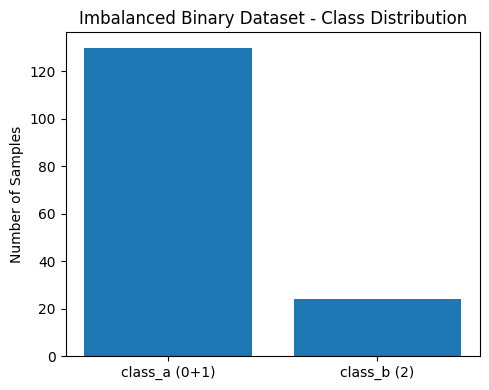

In [32]:
# Check class distribution
class_counts = df_binary_imbalanced['binary_label'].value_counts().sort_index()
class_labels = ['class_a (0+1)', 'class_b (2)']

# Print counts
for label, count in zip(class_labels, class_counts):
    print(f"{label}: {count} samples")

# Optional: visualize with a bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.bar(class_labels, class_counts)
plt.title("Imbalanced Binary Dataset - Class Distribution")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


In [33]:
print("Test set class distribution:")
print(pd.Series(y_imb).value_counts())

Test set class distribution:
binary_label
0    130
1     24
Name: count, dtype: int64


In [34]:
from collections import Counter
_, X_test_check, _, y_test_check = train_test_split(X_imb, y_imb, test_size=0.2, stratify=y_imb, random_state=42)
print("Test class counts:", Counter(y_test_check))


Test class counts: Counter({0: 26, 1: 5})


In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Labels
labels = ['class_a (0+1)', 'class_b (2)']

# Function to compute class-wise accuracy from confusion matrix
def get_classwise_accuracy(cm):
    return cm.diagonal() / cm.sum(axis=1)

# Function to run 5-fold CV and collect class-wise metrics
def cross_val_classwise_report(models, X, y, label_names):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        print(f"\n==== {model_name} ====")
        acc_all = []
        class_acc_all = {label: [] for label in label_names}
        precision_all = {label: [] for label in label_names}
        recall_all = {label: [] for label in label_names}
        f1_all = {label: [] for label in label_names}

        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            # Accuracy
            acc = accuracy_score(y_val, y_pred)
            acc_all.append(acc)

            # Classification report
            report = classification_report(y_val, y_pred, target_names=label_names, output_dict=True)
            for label in label_names:
                precision_all[label].append(report[label]["precision"])
                recall_all[label].append(report[label]["recall"])
                f1_all[label].append(report[label]["f1-score"])

            # Class-wise accuracy from confusion matrix
            cm = confusion_matrix(y_val, y_pred)
            class_acc = get_classwise_accuracy(cm)
            for i, label in enumerate(label_names):
                class_acc_all[label].append(class_acc[i])

        # Show average results
        print(f"Mean Overall Accuracy: {np.mean(acc_all):.3f}")
        for label in label_names:
            print(f"\n[{label}]")
            print(f"  Class Accuracy: {np.mean(class_acc_all[label]):.3f}")
            print(f"  Precision     : {np.mean(precision_all[label]):.3f}")
            print(f"  Recall        : {np.mean(recall_all[label]):.3f}")
            print(f"  F1 Score      : {np.mean(f1_all[label]):.3f}")

# Run on imbalanced data
cross_val_classwise_report(models, X_imb, y_imb, labels)



==== Naive Bayes ====
Mean Overall Accuracy: 0.987

[class_a (0+1)]
  Class Accuracy: 0.985
  Precision     : 1.000
  Recall        : 0.985
  F1 Score      : 0.992

[class_b (2)]
  Class Accuracy: 1.000
  Precision     : 0.927
  Recall        : 1.000
  F1 Score      : 0.960

==== KNN ====
Mean Overall Accuracy: 0.994

[class_a (0+1)]
  Class Accuracy: 0.992
  Precision     : 1.000
  Recall        : 0.992
  F1 Score      : 0.996

[class_b (2)]
  Class Accuracy: 1.000
  Precision     : 0.967
  Recall        : 1.000
  F1 Score      : 0.982

==== Gaussian Process ====
Mean Overall Accuracy: 0.980

[class_a (0+1)]
  Class Accuracy: 0.985
  Precision     : 0.993
  Recall        : 0.985
  F1 Score      : 0.988

[class_b (2)]
  Class Accuracy: 0.950
  Precision     : 0.933
  Recall        : 0.950
  F1 Score      : 0.935

==== SVM ====
Mean Overall Accuracy: 0.987

[class_a (0+1)]
  Class Accuracy: 0.992
  Precision     : 0.993
  Recall        : 0.992
  F1 Score      : 0.992

[class_b (2)]
  C